In [1]:
import logging
import numpy as np
import pandas as pd
from arch import arch_model
from random import gauss
from random import seed
from matplotlib import pyplot as plt
import scipy.stats as sts
import json
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.optimize import least_squares
import os
from itertools import product
from pathlib import Path

In [2]:
_cur_dir = os.getcwd()
os.chdir('..')

In [3]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from membership_functions import calc_trapezoidal_membership_degrees
# from membership_functions.trapezoidal import _calc_trapezoidal_md_scalar

In [4]:
with open('config.json') as file:
    config = json.load(file)

In [5]:
INPUT = Path(config['files_folders']['processed'])
RES_DIR = Path(config['files_folders']['research_results'])
OUTPUT = Path(config['files_folders']['calculations_metaparams'])
LOGS_DIR = config['files_folders']['logs']

In [6]:
sec = 'rtsi'

# Main input data

In [7]:
rtsi = pd.read_pickle(INPUT / f'{sec}.pkl')

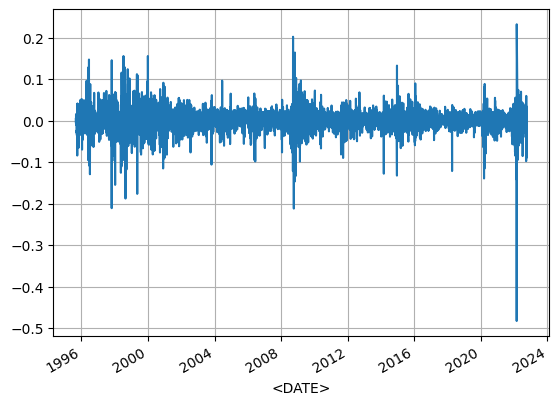

In [8]:
rtsi['log return'].plot()

plt.grid()
plt.show()

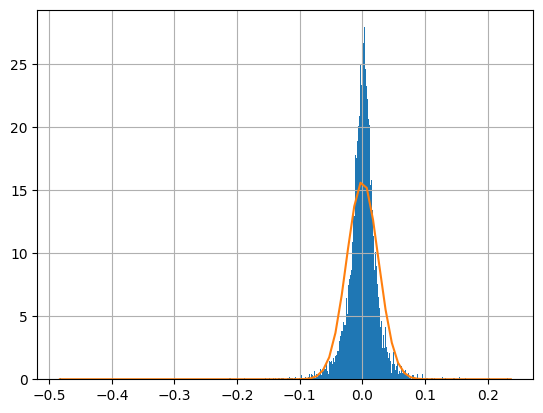

In [9]:
_step = .01
_ran = np.arange(rtsi['log return'].min(), rtsi['log return'].max() + _step, _step)
_norm_pdf = sts.norm(loc=rtsi['log return'].mean(), scale=rtsi['log return'].std()).pdf(_ran)

rtsi['log return'].hist(bins=500, density=True)
plt.plot(_ran, _norm_pdf)

plt.show()

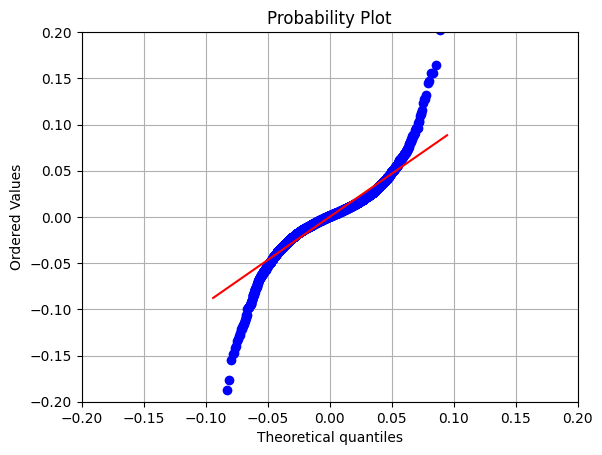

In [10]:
sts.probplot(rtsi['log return'], dist='norm', sparams=(rtsi['log return'].mean(), rtsi['log return'].std()), plot=plt)

_lim = .2
plt.xlim(-_lim, _lim)
plt.ylim(-_lim, _lim)
plt.grid()

In [11]:
rtsi['log return'].describe()

count    6771.000000
mean        0.000354
std         0.025407
min        -0.482921
25%        -0.010185
50%         0.001224
75%         0.011688
max         0.232044
Name: log return, dtype: float64

In [12]:
rtsi['day of week'] = rtsi.index.dayofweek + 1

In [13]:
rtsi['day of week'].value_counts()

3    1364
4    1361
2    1360
5    1340
1    1297
6      34
7      15
Name: day of week, dtype: int64

In [14]:
# rtsi['test triangular cluster memb'] = \
calc_trapezoidal_membership_degrees(rtsi['day of week'].values,
                                    a=[0, 2],
                                    b=[2, 4],
                                    c=[2, 4],
                                    d=[4, 6])

array([0., 0.])

# Constants

In [15]:
rescale_factor = 1
start_date = '2018-01-01'
# end_date = '2020-12-31'
n_sample = 506 + 126

ret = (rtsi['log return'].loc[start_date:].iloc[:n_sample].copy() * rescale_factor).copy()

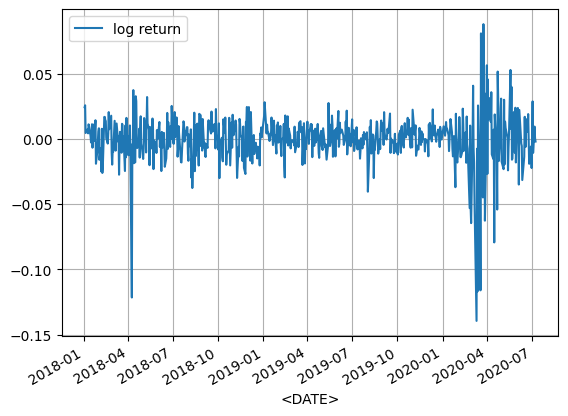

In [16]:
# input_data.plot(label='ARMA errors, input data')
ret.plot(label='log return')

plt.legend()
plt.grid()
plt.show()

In [17]:
ret.describe()

count    632.000000
mean       0.000120
std        0.018502
min       -0.139486
25%       -0.007383
50%        0.001316
75%        0.009446
max        0.088251
Name: log return, dtype: float64

In [18]:
n = ret.shape[0]

In [19]:
n

632

# Train / test split

In [20]:
n_train = 1

n_test = 252
# n_test = min(n - n_train, n_test)
train_end = '2019-12-31'

In [21]:
ret_train, ret_test = ret.iloc[:n_train].copy(), ret.iloc[n_train:].copy()

train_mean = ret_train.mean()
train = (ret_train - train_mean).copy()
test = (ret - ret.expanding().mean()).iloc[n_train:].copy()

In [22]:
# train, test = ret.iloc[:n_train].copy(), ret.iloc[n_train:(n_train + n_test)].copy()
# train, test = ret.loc[:train_end].copy(), ret[train_end:].iloc[:n_test].copy()
input_cut = pd.concat([train, test]).copy()
# data_to_cluster_train, data_to_cluster_test = days_of_week.iloc[:n_train].copy(), days_of_week.iloc[n_train:].copy()

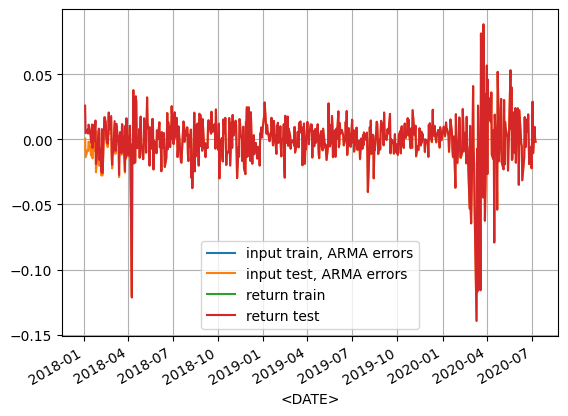

In [23]:
train.plot(label='input train, ARMA errors')
test.plot(label='input test, ARMA errors')
ret_train.plot(label='return train')
ret_test.plot(label='return test')

plt.legend()
plt.grid()
plt.show()

# Consequent

In [24]:
# general parameters
local_method = 'garch'

# GARCH hyperparameters
p = 1
q = 1

starting_index = max(p, q)

train_sample_std = train.std()
first_h = [train_sample_std ** 2] * starting_index
first_h = np.array(first_h)

# parameters constraints
lower_bounds = [0] * (1 + p + q)
upper_bounds = [+np.inf] + [1] * (p + q)
bounds = (lower_bounds, upper_bounds)

# consequent estimator params
rls_omega = 1e0

## initial parameters values

In [25]:
parameters_ini = {
    'alpha_0': np.array([0]),
    'alpha': np.array([[0]]),
    'beta': np.array([[0]])
}

## Setting dict w/ all consequent parameters

In [26]:
consequent_metaparams = {'p': p, 'q': q, 'first_h': first_h,
                         'bounds': bounds, 'parameters_ini': parameters_ini}

# Other params

In [27]:
data_to_cluster_train = train.iloc[:1].to_frame()
data_to_cluster_test = test.to_frame().copy()

In [28]:
normalize = True

n_points_fitting = None  # 252 * 2

optimization = 'rls'
optimization_parameters = {}

past_h_type = 'rule-wise'

# Antecedent parameters

In [29]:
variance = .02 * rescale_factor
n_clusters = 1
sigma = 0
potentials_focal = np.array([1] * n_clusters)
delta_min = variance * 1e-6

clusterization_parameters = {
    'n_clusters': n_clusters,
#     'centers': centers,
    'variance': variance,
    'sigma': sigma,
#     'beta': beta,
    'potentials_focal': potentials_focal,
    'delta_min': delta_min
}

## $h_t = \alpha_0 + \sum_{i = 1}^{q} \alpha_i y_{t - i}^2 + \sum_{j = 1}^{p} \beta_j h_{t - j}$

## $p = 1$, $q = 1$

## $x_t = (y_{t - 1}, h_{t - 1})$ or $x_t = (y_{t - 1})$

In [30]:
x_dim = q  # p + q + 1 is also possible (if output value y_t is also used for clustering)

centers = np.array([data_to_cluster_train.iloc[0].values]).copy()
beta = np.array([0] * x_dim)

clusterization_parameters.update({
    'x_dim': x_dim,
    'centers': centers,
    'beta': beta
})

In [31]:
clusterization_method = 'eTS'
membership_function = 'gaussian'

In [32]:
n_last_points_to_use_for_clustering = None

# Antecedent-dependent consequent params

In [33]:
first_h_1d = [train[0] ** 2] * starting_index
first_h = np.array([first_h_1d for _ in range(n_clusters)]).T.copy()

# Aggregating all data to one dict

In [34]:
fvm_ini_params = {
    'train_data': train,
    'clusterization_method': clusterization_method,
    'membership_function': membership_function,
    'clusterization_parameters': clusterization_parameters,
    'local_method': local_method,
    'local_method_parameters': consequent_metaparams,
    'n_last_points_to_use_for_clustering': n_last_points_to_use_for_clustering,
    'data_to_cluster': data_to_cluster_train,
    'normalize': normalize,
    'n_points_fitting': n_points_fitting,
    'first_h': first_h,
    'optimization': optimization,
    'optimization_parameters': optimization_parameters,
    'clustered_space_dim': x_dim,
    'past_h_type': past_h_type,
    'rls_omega': rls_omega
}

fvm_test_params = {
    'test_data': test,
    'data_to_cluster': data_to_cluster_test
}

_train_start = str(train.index[0]).split(' ')[0]
_n_train = train.shape[0]
_n_test = test.shape[0]
_n_retrain = fvm_ini_params['n_points_fitting']
_desc = {
    'series_name': sec,
    'train_start': _train_start,
    'n_train': _n_train,
    'n_test': _n_test,
    'n_retrain': _n_retrain,
    'M': n_last_points_to_use_for_clustering
}

data = {
    'fvm_ini_params': fvm_ini_params,
    'fvm_test_params': fvm_test_params,
    '_desc': _desc
}

# Dumping

In [35]:
_file_name_cur = 'current_fvm_ets_metadata.pkl'

_cur_time = str(pd.Timestamp.now().floor('s'))
_str_desc = str(_desc).replace(':', '=').replace("""'""", '')
_file_name_hist = f'hist_fvm_ets_metadata_{_str_desc}_{_cur_time}.pkl'.replace(' ', '_').replace(':', '-')

with open(OUTPUT / _file_name_cur, 'wb') as _file:
    pickle.dump(data, _file)

with open(OUTPUT / _file_name_hist, 'wb') as _file:
    pickle.dump(data, _file)